In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss
import sys

sys.path.append("../")

from src.common_functions import *

In [2]:
# sample data
# RAW_DATA_PATH1 = "../datasets/fraud/fraudTrain.csv"
# RAW_DATA_PATH2 = "../datasets/fraud/fraudTest.csv"
SAMPLED_DATA_PATH = "../datasets/fraud/cc_fraud_2.csv"
DATASET_NAME = Path(SAMPLED_DATA_PATH).stem
# raw_data1 = pd.read_csv("../datasets/fraud/fraudTrain.csv", index_col='Unnamed: 0')
# raw_data2 = pd.read_csv("../datasets/fraud/fraudTest.csv", index_col='Unnamed: 0')
# raw_data = pd.concat([raw_data1, raw_data2])
# raw_data = raw_data.rename(columns=dict(zip(raw_data.columns, list(map(to_snake_case, raw_data.columns)))))
# raw_data.head()
# _to_drop, df = train_test_split(raw_data, test_size=0.055, random_state=42, stratify=raw_data["is_fraud"])
# df.to_csv(SAMPLED_DATA_PATH, header=True, sep=",")
# del _to_drop
df = pd.read_csv(SAMPLED_DATA_PATH, index_col='Unnamed: 0')
print(df.shape[0])
df["is_fraud"].value_counts()/df.shape[0]*100

101882


is_fraud
0    99.478809
1     0.521191
Name: count, dtype: float64

In [3]:
df.isna().any()

trans_date_trans_time    False
cc_num                   False
merchant                 False
category                 False
amt                      False
first                    False
last                     False
gender                   False
street                   False
city                     False
state                    False
zip                      False
lat                      False
long                     False
city_pop                 False
job                      False
dob                      False
trans_num                False
unix_time                False
merch_lat                False
merch_long               False
is_fraud                 False
dtype: bool

In [4]:
numerical_columns = df.select_dtypes(
        include='number').columns.to_list()
numerical_columns

['cc_num',
 'amt',
 'zip',
 'lat',
 'long',
 'city_pop',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

In [5]:
pd.set_option('display.max_columns', None)

df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
81955,2019-02-18 05:13:53,30442439074871,fraud_Prohaska-Murray,gas_transport,84.50,Linda,Sanchez,F,6574 William Hill Apt. 375,Jermyn,PA,18433,41.5744,-75.5881,6508,Training and development officer,1981-06-22,e87d0600784494b1fa22cc39ee43a664,1329542033,41.415102,-74.742120,0
105389,2020-07-27 21:39:15,4599735407877245080,fraud_Crona and Sons,kids_pets,141.70,Mary,Myers,F,39787 Pamela Fall Suite 639,Tiptonville,TN,38079,36.3846,-89.4649,5577,Geochemist,1964-12-30,aa521d71ed29b262ed53702992785426,1374961155,35.532554,-89.097033,0
442525,2020-12-07 04:50:50,375848982312810,fraud_Erdman-Kertzmann,gas_transport,92.17,Dale,Smith,M,25036 Contreras Turnpike Suite 270,Purmela,TX,76566,31.4841,-97.9903,258,Web designer,1943-12-15,ebdbe410178c5365013842e9555aac59,1386391850,30.521008,-97.837087,0
916621,2019-12-30 03:31:10,375237305371366,fraud_Sawayn PLC,shopping_pos,9.89,David,Erickson,M,616 Jimenez Meadow Apt. 701,East Rochester,NY,14445,43.1128,-77.4906,8019,Retail buyer,1928-06-26,ff86e07988b326802e76ef0db08dc994,1356838270,42.571261,-78.185175,0
117618,2019-03-07 18:03:51,4607072969078276,fraud_Abbott-Steuber,personal_care,13.98,Brenda,Perez,F,033 Tara Brook Suite 523,Coyle,OK,73027,35.8985,-97.2607,1493,Amenity horticulturist,1985-03-21,bff6baa0a339d57d105bd587012d35a9,1331143431,36.858453,-97.334306,0


In [6]:
df.dtypes

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [7]:
import numpy as np

def preprocess_lat_lon(df:pd.DataFrame, lat_col_name:str="latitude", lon_col_name:str="longitude") -> pd.DataFrame:
    """
    Preprocesses latitude and longitude columns.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to preprocess.
    lat_col_name : str
        The name of the latitude column.
    lon_col_name : str
        The name of the longitude column.
        
    Returns
    -------
    pd.DataFrame
        The preprocessed dataframe.
    """
    # Convert to radians
    df[f"{lat_col_name}_x"] = np.cos(df[lat_col_name]) * np.cos(df[lon_col_name])
    df[f"{lon_col_name}_y"] = np.cos(df[lat_col_name]) * np.sin(df[lon_col_name])
    df[f"{lat_col_name}_z"] = np.sin(df[lat_col_name])
    return df.drop([lat_col_name, lon_col_name], axis=1)

In [8]:
y = "is_fraud"

# some generic cleaning
# Amt - amount of the transaction in local currency
# otherwise unrecognized cases in test set
counts = df.value_counts([y, "job"])
jobs_to_filter = counts[counts==1].reset_index()["job"].unique()
df = df.loc[~df.job.isin(jobs_to_filter)]

COLUMNS_TO_DROP = ["city", "trans_date_trans_time", "merchant", "first", "last", "street", "zip", "trans_num", "dob"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

raw_features = raw_features.transform(preprocess_lat_lon, lat_col_name="lat", lon_col_name="long")
raw_features = raw_features.transform(preprocess_lat_lon, lat_col_name="merch_lat", lon_col_name="merch_long")

# ML tuning
train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[[y, "job"]])

fit_le = LabelEncoder().fit(train[y])

In [9]:
pipeline = build_sklearn_pipeline(train, y, "logistic", LogisticRegression())
pipeline.fit(train.drop(y, axis=1), train[y])
print(Pipeline(pipeline.steps[:-1]).transform(train.drop(y, axis=1)).shape)
pipeline.predict(train.drop(y, axis=1))

(54081, 384)


array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [10]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [10, 20,30],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose=1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^

Best score: 0.8992830536063746
Best parameters: {'logistic__C': 10, 'logistic__penalty': 'l2', 'over__sampling_strategy': 0.7, 'pca__n_components': 30, 'under__sampling_strategy': 0.3}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cc_num', 'amt', 'city_pop',
                                                   'unix_time', 'lat_x',
                                                   'long_y', 'lat_z',
                                                   'merch_lat_x',
                                                   'merch_long_y',
                                                   'merch_lat_z']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['category', 'gender',
                                                   'state', 'job'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.3)),
                ('over', SMOTE(sampling_strategy=0.7)),
                ('pca', PCA(n_components=30)),
                ('logistic', LogisticRegression(C=10))])

In [11]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [12]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,0.1,0.2,10,1,l2,0.845468,0.044246
108,0.1,0.2,10,10,l2,0.846917,0.043570
216,0.1,0.2,10,100,l2,0.844820,0.046327
324,0.1,0.2,10,1000,l2,0.843996,0.042513
6,0.1,0.2,20,1,l2,0.887340,0.026434
...,...,...,...,...,...,...,...
424,0.7,1.0,20,1000,l2,0.872491,0.025637
106,0.7,1.0,30,1,l2,0.894329,0.027414
214,0.7,1.0,30,10,l2,0.893799,0.021094
322,0.7,1.0,30,100,l2,0.892657,0.034721


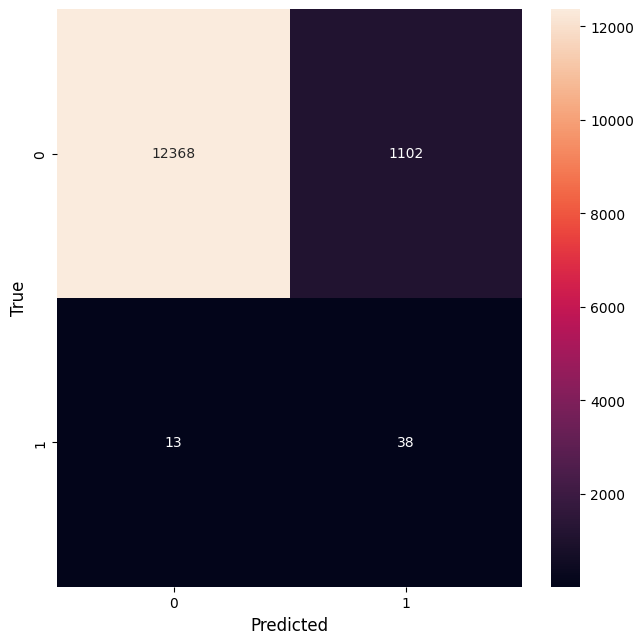

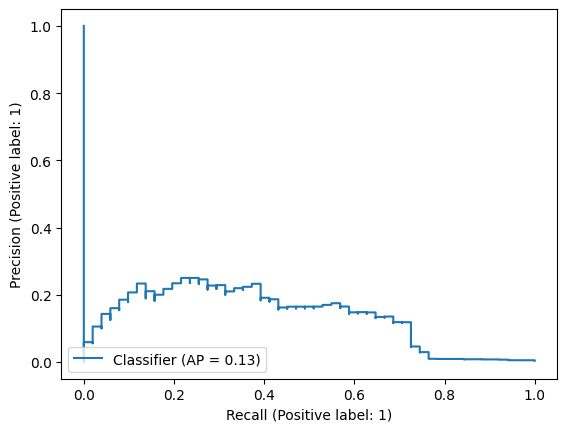

In [13]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name = 'logistic')

In [14]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized = True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.929142712569119
Best parameters: {'xgb__subsample': 1.0, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 10, 'xgb__max_depth': 3, 'xgb__gamma': 0.5, 'xgb__colsample_bytree': 1.0, 'under__sampling_strategy': 0.2, 'pca__n_components': 30, 'over__sampling_strategy': 0.4}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cc_num', 'amt', 'city_pop',
                                                   'unix_time', 'lat_x',
                                                   'long_y', 'lat_z',
                                                   'merch_lat_x',
                                                   'merch_long_y',
                                                   'merch_lat_z']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent...
                               feature_types=None, gamma=0.5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [15]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

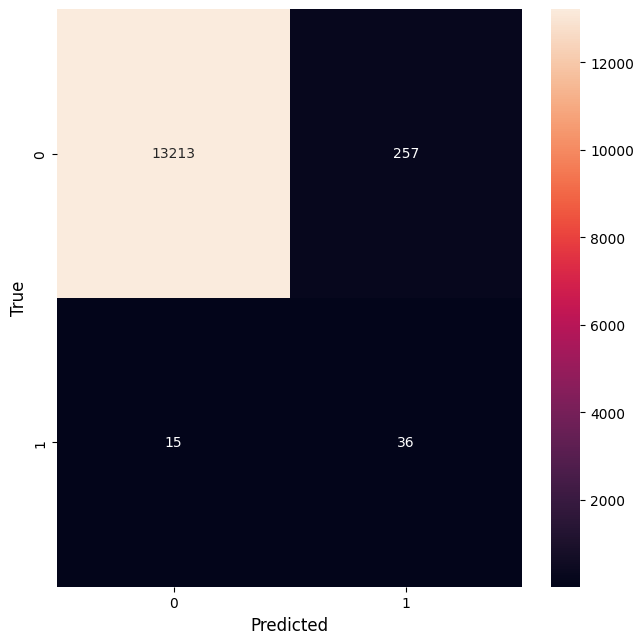

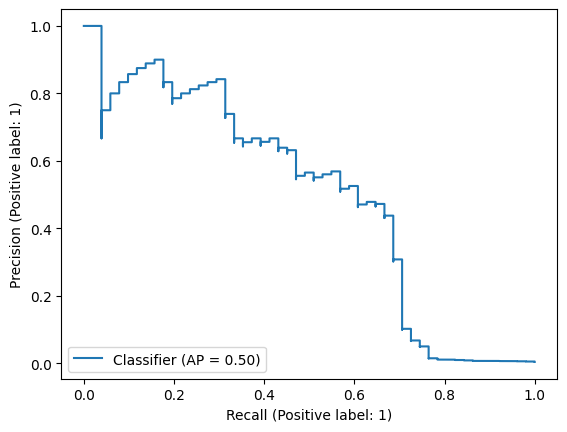

In [16]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [17]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# evaluation metrics

In [18]:
test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log["churn_encoded"] = fit_le.transform(test_predictions_log["is_fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test_predictions_log["amt"]*2000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['is_fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))

Test cost/loss = 1672.
 total cost/loss average :  0.12364691960653797


In [19]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["is_fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["amt"]*2000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['is_fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))

Test cost/loss = 1720.
 total cost/loss average :  0.12718955698543005


In [20]:


print(test_predictions_log[['is_fraud', "A", 'instance_cost', "y_predicted"]].head(30))

         is_fraud          A  instance_cost  y_predicted
377359          0   125260.0            0.0            0
343471          0   134020.0            0.0            0
858312          0    35100.0            0.0            0
653694          0    64280.0            0.0            0
485688          0   137480.0            0.0            0
381035          0   240020.0            0.0            0
513268          0   103860.0            0.0            0
430783          0   155440.0            0.0            0
345889          0   193300.0            0.0            0
953633          0    92920.0            0.0            0
280700          0    15300.0            0.0            0
136120          0   354980.0            1.0            1
52731           0   297420.0            0.0            0
683053          0    81440.0            0.0            0
1201668         0   149280.0            0.0            0
1130978         0    12100.0            0.0            0
156956          1  2389120.0   

# AMC metric

Decision Threshold: 0.01, Test cost/loss = 11397.00
Decision Threshold: 0.02, Test cost/loss = 10641.00
Decision Threshold: 0.03, Test cost/loss = 10155.81
Decision Threshold: 0.04, Test cost/loss = 9690.81
Decision Threshold: 0.05, Test cost/loss = 9268.81
Decision Threshold: 0.06, Test cost/loss = 8852.81
Decision Threshold: 0.07, Test cost/loss = 8456.81
Decision Threshold: 0.08, Test cost/loss = 8087.81
Decision Threshold: 0.09, Test cost/loss = 7734.81
Decision Threshold: 0.10, Test cost/loss = 7419.81
Decision Threshold: 0.11, Test cost/loss = 7126.81
Decision Threshold: 0.12, Test cost/loss = 6892.91
Decision Threshold: 0.13, Test cost/loss = 6636.91
Decision Threshold: 0.14, Test cost/loss = 6420.91
Decision Threshold: 0.15, Test cost/loss = 6187.37
Decision Threshold: 0.16, Test cost/loss = 5960.11
Decision Threshold: 0.17, Test cost/loss = 5765.11
Decision Threshold: 0.18, Test cost/loss = 5561.43
Decision Threshold: 0.19, Test cost/loss = 5352.43
Decision Threshold: 0.20, Te

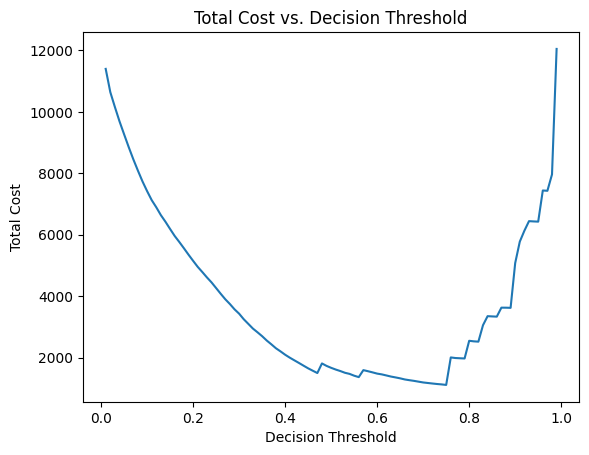

In [21]:
cb_column = 'A'
test_predictions_log['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud')

Decision Threshold: 0.01, Test cost/loss = 8642.60
Decision Threshold: 0.02, Test cost/loss = 6771.30
Decision Threshold: 0.03, Test cost/loss = 5581.04
Decision Threshold: 0.04, Test cost/loss = 4747.38
Decision Threshold: 0.05, Test cost/loss = 4138.19
Decision Threshold: 0.06, Test cost/loss = 3685.72
Decision Threshold: 0.07, Test cost/loss = 3287.72
Decision Threshold: 0.08, Test cost/loss = 2972.72
Decision Threshold: 0.09, Test cost/loss = 2708.18
Decision Threshold: 0.10, Test cost/loss = 2497.18
Decision Threshold: 0.11, Test cost/loss = 2313.18
Decision Threshold: 0.12, Test cost/loss = 2140.18
Decision Threshold: 0.13, Test cost/loss = 1956.18
Decision Threshold: 0.14, Test cost/loss = 1818.18
Decision Threshold: 0.15, Test cost/loss = 1703.18
Decision Threshold: 0.16, Test cost/loss = 1607.18
Decision Threshold: 0.17, Test cost/loss = 1509.18
Decision Threshold: 0.18, Test cost/loss = 1427.18
Decision Threshold: 0.19, Test cost/loss = 1361.18
Decision Threshold: 0.20, Test 

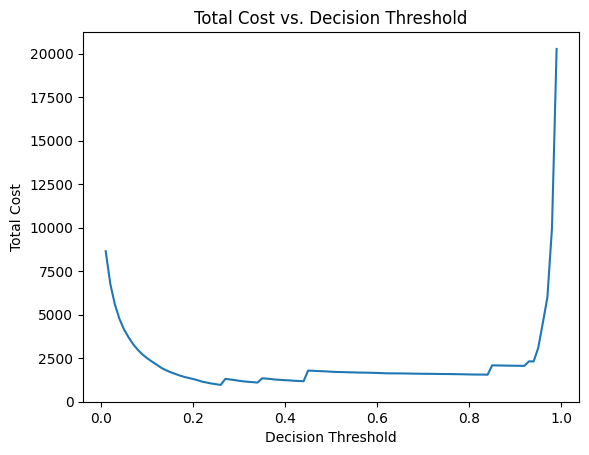

In [22]:
test_predictions_xgb['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'fraud' )

# E-AMC

In [23]:
test_predictions_log = add_eap_ep(
    train=train, 
    test=test_predictions_log, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="fraud")
test_predictions_xgb = add_eap_ep(
    train=train, 
    test=test_predictions_xgb, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [24]:
test_predictions_log

,cc_num,category,amt,gender,state,city_pop,job,unix_time,is_fraud,lat_x,long_y,lat_z,merch_lat_x,merch_long_y,merch_lat_z,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
377359,3540210836308425,food_dining,62.63,M,TX,53,Fisheries officer,1384536888,0,0.386883,0.903359,-0.185107,0.974763,0.171631,-0.142757,0,0,125260.0,0.00,0,0.110216,0,62.63,1,0,0.110216,0.005658
343471,639030014711,entertainment,67.01,M,IL,639,Mechanical engineer,1383260389,0,0.374299,-0.790767,-0.484343,-0.101118,-0.751755,-0.651644,0,0,134020.0,0.00,0,0.003970,0,67.01,1,0,0.003970,0.005658
858312,377264520876399,personal_care,17.55,F,SC,4424,Lawyer,1355689325,0,-0.370872,-0.903818,0.213464,-0.117634,-0.817296,-0.564083,0,0,35100.0,0.00,0,0.127135,0,17.55,1,0,0.127135,0.005658
653694,213157767990030,health_fitness,32.14,F,WY,27971,Music therapist,1349466301,0,0.539446,0.478639,-0.692750,-0.001038,-0.002552,-0.999996,0,0,64280.0,0.00,0,0.138715,0,32.14,1,0,0.138715,0.005658
485688,30408301059761,kids_pets,68.74,M,SC,4471,Occupational hygienist,1343748738,0,-0.025769,-0.341624,0.939483,0.190030,-0.354266,0.915633,0,0,137480.0,0.00,0,0.381609,0,68.74,1,0,0.381609,0.005658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202685,374821819075109,health_fitness,19.34,M,NY,9565,Exhibition designer,1368835137,1,-0.151494,-0.586493,-0.795660,0.420107,-0.862442,-0.282320,0,1,38680.0,19.34,0,0.221355,0,19.34,1,0,15.058990,19.230571
670176,4266200684857219,shopping_net,1083.88,M,NE,732,Television/film/video producer,1350086058,1,0.624315,-0.503856,0.596958,0.691758,0.004403,0.722116,1,1,2167760.0,0.00,1,0.999037,0,1083.88,1,0,1.043415,1077.747213
1131211,4810789809665942990,entertainment,544.79,F,OH,338,Quantity surveyor,1366066429,1,0.134441,0.269255,0.953639,-0.021650,0.099756,0.994776,1,1,1089580.0,544.79,1,0.979851,0,544.79,1,0,10.977079,541.707480
90178,4195740185974,grocery_pos,314.36,M,OR,841711,"Engineer, building services",1374463871,1,-0.022418,0.004107,0.999740,-0.325970,-0.031024,0.944871,1,1,628720.0,314.36,1,0.795012,0,314.36,1,0,64.440144,312.581295


In [25]:
test_predictions_xgb

,cc_num,category,amt,gender,state,city_pop,job,unix_time,is_fraud,lat_x,long_y,lat_z,merch_lat_x,merch_long_y,merch_lat_z,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
377359,3540210836308425,food_dining,62.63,M,TX,53,Fisheries officer,1384536888,0,0.386883,0.903359,-0.185107,0.974763,0.171631,-0.142757,0,0,125260.0,0.00,0,0.012986,0,62.63,1,0,0.012986,0.005658
343471,639030014711,entertainment,67.01,M,IL,639,Mechanical engineer,1383260389,0,0.374299,-0.790767,-0.484343,-0.101118,-0.751755,-0.651644,0,0,134020.0,0.00,0,0.003323,0,67.01,1,0,0.003323,0.005658
858312,377264520876399,personal_care,17.55,F,SC,4424,Lawyer,1355689325,0,-0.370872,-0.903818,0.213464,-0.117634,-0.817296,-0.564083,0,0,35100.0,0.00,0,0.019063,0,17.55,1,0,0.019063,0.005658
653694,213157767990030,health_fitness,32.14,F,WY,27971,Music therapist,1349466301,0,0.539446,0.478639,-0.692750,-0.001038,-0.002552,-0.999996,0,0,64280.0,0.00,0,0.046772,0,32.14,1,0,0.046772,0.005658
485688,30408301059761,kids_pets,68.74,M,SC,4471,Occupational hygienist,1343748738,0,-0.025769,-0.341624,0.939483,0.190030,-0.354266,0.915633,0,0,137480.0,0.00,0,0.006654,0,68.74,1,0,0.006654,0.005658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202685,374821819075109,health_fitness,19.34,M,NY,9565,Exhibition designer,1368835137,1,-0.151494,-0.586493,-0.795660,0.420107,-0.862442,-0.282320,0,1,38680.0,19.34,0,0.031820,0,19.34,1,0,18.724608,19.230571
670176,4266200684857219,shopping_net,1083.88,M,NE,732,Television/film/video producer,1350086058,1,0.624315,-0.503856,0.596958,0.691758,0.004403,0.722116,1,1,2167760.0,0.00,1,0.991832,0,1083.88,1,0,8.853565,1077.747213
1131211,4810789809665942990,entertainment,544.79,F,OH,338,Quantity surveyor,1366066429,1,0.134441,0.269255,0.953639,-0.021650,0.099756,0.994776,1,1,1089580.0,544.79,1,0.846843,0,544.79,1,0,83.438237,541.707480
90178,4195740185974,grocery_pos,314.36,M,OR,841711,"Engineer, building services",1374463871,1,-0.022418,0.004107,0.999740,-0.325970,-0.031024,0.944871,1,1,628720.0,314.36,1,0.953962,0,314.36,1,0,14.472553,312.581295


In [26]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

4000.868800703722
26764.698161091692
EAP :  0.29590036245127743
EP :  1.9794910258924407


In [27]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

2407.964083171541
26764.698161091692
EAP :  0.17809067991801944
EP :  1.9794910258924407


# mp 50% threshold

In [28]:
test_predictions_log_2= test.copy(deep=True)
test_predictions_log_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_2.drop(y, axis=1))
test_predictions_log_2["churn_encoded"] = fit_le.transform(test_predictions_log_2["is_fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_2['A'] = impute.fit_transform(
    (test_predictions_log_2["amt"]*2000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_2['instance_cost'] = test_predictions_log_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_2[['is_fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_2['instance_cost'].sum()/len(test_predictions_log_2))

Test cost/loss = -1634.
 total cost/loss average :  -0.12083647659196804


In [29]:
test_predictions_xgb_2 = test.copy(deep=True)
test_predictions_xgb_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_2.drop(y, axis=1))
test_predictions_xgb_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_2["is_fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_2['A'] = impute.fit_transform(
    (test_predictions_xgb_2["amt"]*2000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_2['instance_cost'] = test_predictions_xgb_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_2[['is_fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_2['instance_cost'].sum()/len(test_predictions_xgb_2))

Test cost/loss = -1684.
 total cost/loss average :  -0.12452703202425855


# mp-metric

Decision Threshold: 0.01, Test cost/loss = -11346.00
Decision Threshold: 0.02, Test cost/loss = -10590.00
Decision Threshold: 0.03, Test cost/loss = -10105.81
Decision Threshold: 0.04, Test cost/loss = -9641.81
Decision Threshold: 0.05, Test cost/loss = -9220.81
Decision Threshold: 0.06, Test cost/loss = -8804.81
Decision Threshold: 0.07, Test cost/loss = -8408.81
Decision Threshold: 0.08, Test cost/loss = -8039.81
Decision Threshold: 0.09, Test cost/loss = -7686.81
Decision Threshold: 0.10, Test cost/loss = -7371.81
Decision Threshold: 0.11, Test cost/loss = -7078.81
Decision Threshold: 0.12, Test cost/loss = -6845.91
Decision Threshold: 0.13, Test cost/loss = -6589.91
Decision Threshold: 0.14, Test cost/loss = -6373.91
Decision Threshold: 0.15, Test cost/loss = -6141.37
Decision Threshold: 0.16, Test cost/loss = -5915.11
Decision Threshold: 0.17, Test cost/loss = -5720.11
Decision Threshold: 0.18, Test cost/loss = -5518.43
Decision Threshold: 0.19, Test cost/loss = -5309.43
Decision 

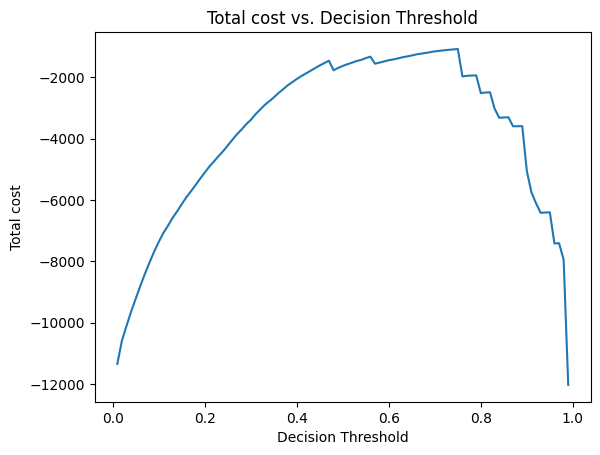

In [30]:
cb_column = 'A'
test_predictions_log_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_2, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud_2')


Decision Threshold: 0.01, Test cost/loss = -8593.60
Decision Threshold: 0.02, Test cost/loss = -6726.30
Decision Threshold: 0.03, Test cost/loss = -5537.04
Decision Threshold: 0.04, Test cost/loss = -4704.38
Decision Threshold: 0.05, Test cost/loss = -4096.19
Decision Threshold: 0.06, Test cost/loss = -3645.72
Decision Threshold: 0.07, Test cost/loss = -3247.72
Decision Threshold: 0.08, Test cost/loss = -2932.72
Decision Threshold: 0.09, Test cost/loss = -2669.18
Decision Threshold: 0.10, Test cost/loss = -2458.18
Decision Threshold: 0.11, Test cost/loss = -2274.18
Decision Threshold: 0.12, Test cost/loss = -2101.18
Decision Threshold: 0.13, Test cost/loss = -1917.18
Decision Threshold: 0.14, Test cost/loss = -1779.18
Decision Threshold: 0.15, Test cost/loss = -1664.18
Decision Threshold: 0.16, Test cost/loss = -1568.18
Decision Threshold: 0.17, Test cost/loss = -1470.18
Decision Threshold: 0.18, Test cost/loss = -1388.18
Decision Threshold: 0.19, Test cost/loss = -1322.18
Decision Thr

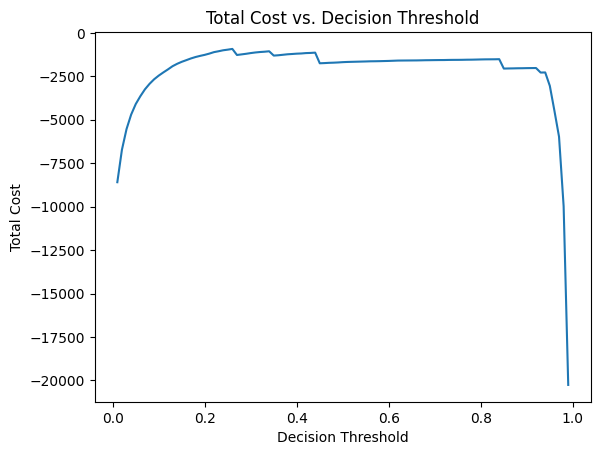

In [31]:
test_predictions_xgb_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'fraud_2' )

# E-MP metric

In [32]:
test_predictions_log_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="fraud_2")
test_predictions_xgb_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [33]:
print(test_predictions_log_2['EAP'].sum())
print(test_predictions_log_2['EP'].sum())


print('EAP : ', test_predictions_log_2['EAP'].sum()/len(test_predictions_log_2))
print('EP : ', test_predictions_log_2['EP'].sum()/len(test_predictions_log_2))

-3963.5334027620956
-26764.409593942415
EAP :  -0.2931390727580871
EP :  -1.979469683746943


In [34]:
print(test_predictions_xgb_2['EAP'].sum())
print(test_predictions_xgb_2['EP'].sum())


print('EAP : ', test_predictions_xgb_2['EAP'].sum()/len(test_predictions_xgb_2))
print('EP : ', test_predictions_xgb_2['EP'].sum()/len(test_predictions_xgb_2))

-2371.3778110915778
-26764.409593942415
EAP :  -0.17538479484443295
EP :  -1.979469683746943


In [35]:
test_predictions_log_2

,cc_num,category,amt,gender,state,city_pop,job,unix_time,is_fraud,lat_x,long_y,lat_z,merch_lat_x,merch_long_y,merch_lat_z,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
377359,3540210836308425,food_dining,62.63,M,TX,53,Fisheries officer,1384536888,0,0.386883,0.903359,-0.185107,0.974763,0.171631,-0.142757,0,0,125260.0,0.00,0,0.110216,0,-62.63,-1,1,-0.110216,-0.005658
343471,639030014711,entertainment,67.01,M,IL,639,Mechanical engineer,1383260389,0,0.374299,-0.790767,-0.484343,-0.101118,-0.751755,-0.651644,0,0,134020.0,0.00,0,0.003970,0,-67.01,-1,1,-0.003970,-0.005658
858312,377264520876399,personal_care,17.55,F,SC,4424,Lawyer,1355689325,0,-0.370872,-0.903818,0.213464,-0.117634,-0.817296,-0.564083,0,0,35100.0,0.00,0,0.127135,0,-17.55,-1,1,-0.127135,-0.005658
653694,213157767990030,health_fitness,32.14,F,WY,27971,Music therapist,1349466301,0,0.539446,0.478639,-0.692750,-0.001038,-0.002552,-0.999996,0,0,64280.0,0.00,0,0.138715,0,-32.14,-1,1,-0.138715,-0.005658
485688,30408301059761,kids_pets,68.74,M,SC,4471,Occupational hygienist,1343748738,0,-0.025769,-0.341624,0.939483,0.190030,-0.354266,0.915633,0,0,137480.0,0.00,0,0.381609,0,-68.74,-1,1,-0.381609,-0.005658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202685,374821819075109,health_fitness,19.34,M,NY,9565,Exhibition designer,1368835137,1,-0.151494,-0.586493,-0.795660,0.420107,-0.862442,-0.282320,0,1,38680.0,-19.34,0,0.221355,0,-19.34,-1,1,-14.837634,-19.224913
670176,4266200684857219,shopping_net,1083.88,M,NE,732,Television/film/video producer,1350086058,1,0.624315,-0.503856,0.596958,0.691758,0.004403,0.722116,1,1,2167760.0,1.00,1,0.999037,0,-1083.88,-1,1,-0.044377,-1077.741554
1131211,4810789809665942990,entertainment,544.79,F,OH,338,Quantity surveyor,1366066429,1,0.134441,0.269255,0.953639,-0.021650,0.099756,0.994776,1,1,1089580.0,-544.79,1,0.979851,0,-544.79,-1,1,-9.997229,-541.701822
90178,4195740185974,grocery_pos,314.36,M,OR,841711,"Engineer, building services",1374463871,1,-0.022418,0.004107,0.999740,-0.325970,-0.031024,0.944871,1,1,628720.0,-314.36,1,0.795012,0,-314.36,-1,1,-63.645133,-312.575637


# cost- curves

In [36]:
len(test_predictions_log['FP'])

13521

In [37]:
total_fp_log = 0

for i in range(0,13521):
    if test_predictions_log['churn_encoded'].iloc[i] == 0 and test_predictions_log['y_predicted'].iloc[i]==1:
        total_fp_log += test_predictions_log['FP'].iloc[i]
    else:
        total_fp_log += 0

print(total_fp_log)

average_fp_log = total_fp_log/13521
print( average_fp_log)

1102
0.08150284742252792


In [38]:
total_fn_log = 0

for i in range(0,13521):
    if test_predictions_log['churn_encoded'].iloc[i] == 1 and test_predictions_log['y_predicted'].iloc[i]==0:
        total_fn_log += test_predictions_log['FN'].iloc[i]
    else:
        total_fn_log += 0

print(total_fn_log)

average_fn_log = total_fn_log/13521
print( average_fn_log)

569.83
0.04214407218401006


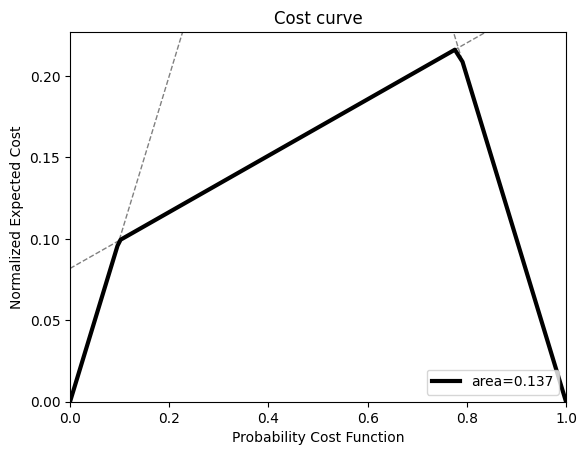

In [39]:
# C(-|+)
cost_fn_log = average_fn_log
# C(+|-)
cost_fp_log = average_fp_log

# Ground truth
truth = test_predictions_log['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log) / (thresholds*cost_fn_log + (1-thresholds)*cost_fp_log)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [40]:
total_fp_xgb = 0

for i in range(0,13521):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 0 and test_predictions_xgb['y_predicted'].iloc[i]==1:
        total_fp_xgb += test_predictions_xgb['FP'].iloc[i]
    else:
        total_fp_xgb += 0

print(total_fp_xgb)

average_fp_xgb = total_fp_xgb/13521
print( average_fp_xgb)

257
0.01900746986169662


In [41]:
total_fn_xgb = 0

for i in range(0,13521):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 1 and test_predictions_xgb['y_predicted'].iloc[i]==0:
        total_fn_xgb += test_predictions_xgb['FN'].iloc[i]
    else:
        total_fn_xgb += 0

print(total_fn_xgb)

average_fn_xgb = total_fn_xgb/13521
print( average_fn_xgb)

1462.7299999999996
0.10818208712373342


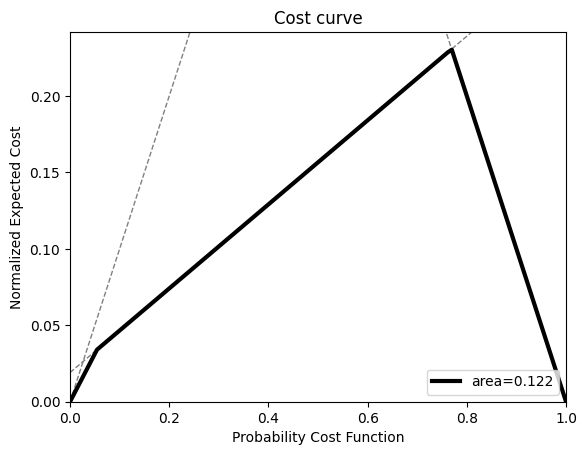

In [42]:
# C(-|+)
cost_fn_xgb = average_fn_xgb
# C(+|-)
cost_fp_xgb = average_fp_xgb

# Ground truth
truth = test_predictions_xgb['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb) / (thresholds*cost_fn_xgb + (1-thresholds)*cost_fp_xgb)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

# from here on we calculate the amc, e-amc, mp and emp but with the churn prediction cost and benefit matrices

# total cost 50% decision threshold

In [43]:
test_predictions_log_churn = test.copy(deep=True)
test_predictions_log_churn["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_churn.drop(y, axis=1))
test_predictions_log_churn["churn_encoded"] = fit_le.transform(test_predictions_log_churn["is_fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_churn['A'] = impute.fit_transform(
    (test_predictions_log["amt"]).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_churn['instance_cost'] = test_predictions_log_churn.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_churn["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_churn["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_churn[['is_fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_churn['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_churn['instance_cost'].sum()/len(test_predictions_log_churn))

Test cost/loss = 164782.
 total cost/loss average :  12.187079358035648


In [44]:
test_predictions_xgb_churn = test.copy(deep=True)
test_predictions_xgb_churn["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_churn.drop(y, axis=1))
test_predictions_xgb_churn["churn_encoded"] = fit_le.transform(test_predictions_xgb_churn["is_fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_churn['A'] = impute.fit_transform(
    (test_predictions_xgb_churn["amt"]).to_frame())[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb_churn['A'] = scaler.fit_transform(test_predictions_xgb_churn['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_churn['instance_cost'] = test_predictions_xgb_churn.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_churn["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_churn["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_churn[['is_fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_churn['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_churn['instance_cost'].sum()/len(test_predictions_xgb_churn))

Test cost/loss = 261509.
 total cost/loss average :  19.340982175874565


# amc metric

Decision Threshold: 0.01, Test cost/loss = 1559774.60
Decision Threshold: 0.02, Test cost/loss = 1453836.06
Decision Threshold: 0.03, Test cost/loss = 1383911.32
Decision Threshold: 0.04, Test cost/loss = 1320684.86
Decision Threshold: 0.05, Test cost/loss = 1257527.82
Decision Threshold: 0.06, Test cost/loss = 1202487.34
Decision Threshold: 0.07, Test cost/loss = 1153666.08
Decision Threshold: 0.08, Test cost/loss = 1104645.52
Decision Threshold: 0.09, Test cost/loss = 1058624.98
Decision Threshold: 0.10, Test cost/loss = 1015631.44
Decision Threshold: 0.11, Test cost/loss = 979978.44
Decision Threshold: 0.12, Test cost/loss = 947338.56
Decision Threshold: 0.13, Test cost/loss = 915266.82
Decision Threshold: 0.14, Test cost/loss = 885639.74
Decision Threshold: 0.15, Test cost/loss = 851147.68
Decision Threshold: 0.16, Test cost/loss = 822216.74
Decision Threshold: 0.17, Test cost/loss = 790372.48
Decision Threshold: 0.18, Test cost/loss = 756717.12
Decision Threshold: 0.19, Test cost/

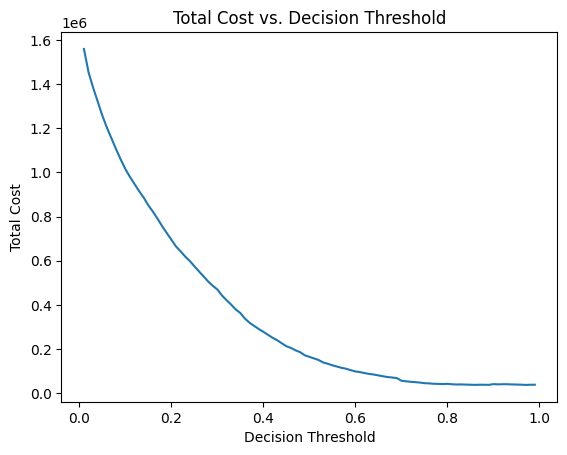

In [45]:
cb_column = 'A'
test_predictions_log_churn['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_churn.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log_churn, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'churn')

Decision Threshold: 0.01, Test cost/loss = 1341998.30
Decision Threshold: 0.02, Test cost/loss = 1119523.74
Decision Threshold: 0.03, Test cost/loss = 980642.62
Decision Threshold: 0.04, Test cost/loss = 882656.28
Decision Threshold: 0.05, Test cost/loss = 811944.98
Decision Threshold: 0.06, Test cost/loss = 754501.50
Decision Threshold: 0.07, Test cost/loss = 704394.64
Decision Threshold: 0.08, Test cost/loss = 666602.66
Decision Threshold: 0.09, Test cost/loss = 629650.16
Decision Threshold: 0.10, Test cost/loss = 598447.00
Decision Threshold: 0.11, Test cost/loss = 572917.58
Decision Threshold: 0.12, Test cost/loss = 548638.56
Decision Threshold: 0.13, Test cost/loss = 523794.86
Decision Threshold: 0.14, Test cost/loss = 503498.12
Decision Threshold: 0.15, Test cost/loss = 487045.98
Decision Threshold: 0.16, Test cost/loss = 470620.26
Decision Threshold: 0.17, Test cost/loss = 455918.72
Decision Threshold: 0.18, Test cost/loss = 443994.94
Decision Threshold: 0.19, Test cost/loss = 4

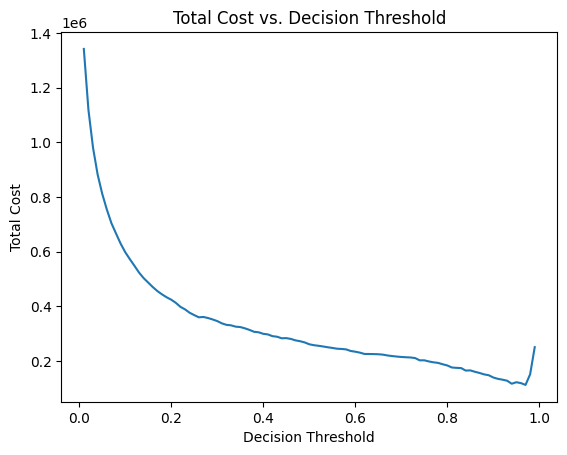

In [46]:
test_predictions_xgb_churn['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_churn.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb_churn, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'churn' )

# E-amc metric

In [47]:
test_predictions_log_churn = add_eap_ep(
    train=train, 
    test=test_predictions_log_churn, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="churn")
test_predictions_xgb_churn = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_churn, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="churn")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [48]:
test_predictions_log_churn

,cc_num,category,amt,gender,state,city_pop,job,unix_time,is_fraud,lat_x,long_y,lat_z,merch_lat_x,merch_long_y,merch_lat_z,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
377359,3540210836308425,food_dining,62.63,M,TX,53,Fisheries officer,1384536888,0,0.386883,0.903359,-0.185107,0.974763,0.171631,-0.142757,0,0,62.63,0.00,0,0.110216,0,751.56,125.26,0,13.805654,0.708744
343471,639030014711,entertainment,67.01,M,IL,639,Mechanical engineer,1383260389,0,0.374299,-0.790767,-0.484343,-0.101118,-0.751755,-0.651644,0,0,67.01,0.00,0,0.003970,0,804.12,134.02,0,0.532077,0.758309
858312,377264520876399,personal_care,17.55,F,SC,4424,Lawyer,1355689325,0,-0.370872,-0.903818,0.213464,-0.117634,-0.817296,-0.564083,0,0,17.55,0.00,0,0.127135,0,210.60,35.10,0,4.462445,0.198602
653694,213157767990030,health_fitness,32.14,F,WY,27971,Music therapist,1349466301,0,0.539446,0.478639,-0.692750,-0.001038,-0.002552,-0.999996,0,0,32.14,0.00,0,0.138715,0,385.68,64.28,0,8.916625,0.363708
485688,30408301059761,kids_pets,68.74,M,SC,4471,Occupational hygienist,1343748738,0,-0.025769,-0.341624,0.939483,0.190030,-0.354266,0.915633,0,0,68.74,0.00,0,0.381609,0,824.88,137.48,0,52.463613,0.777887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202685,374821819075109,health_fitness,19.34,M,NY,9565,Exhibition designer,1368835137,1,-0.151494,-0.586493,-0.795660,0.420107,-0.862442,-0.282320,0,1,153.09,1837.08,0,0.221355,0,1837.08,306.18,0,1430.432716,1826.685472
670176,4266200684857219,shopping_net,1083.88,M,NE,732,Television/film/video producer,1350086058,1,0.624315,-0.503856,0.596958,0.691758,0.004403,0.722116,1,1,52.01,0.00,1,0.999037,0,624.12,104.02,0,0.600819,620.588617
1131211,4810789809665942990,entertainment,544.79,F,OH,338,Quantity surveyor,1366066429,1,0.134441,0.269255,0.953639,-0.021650,0.099756,0.994776,1,1,148.83,1785.96,1,0.979851,0,1785.96,297.66,0,35.985654,1775.854718
90178,4195740185974,grocery_pos,314.36,M,OR,841711,"Engineer, building services",1374463871,1,-0.022418,0.004107,0.999740,-0.325970,-0.031024,0.944871,1,1,87.86,1054.32,1,0.795012,0,1054.32,175.72,0,216.123339,1048.354468


In [49]:
test_predictions_xgb_churn

,cc_num,category,amt,gender,state,city_pop,job,unix_time,is_fraud,lat_x,long_y,lat_z,merch_lat_x,merch_long_y,merch_lat_z,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
377359,3540210836308425,food_dining,62.63,M,TX,53,Fisheries officer,1384536888,0,0.386883,0.903359,-0.185107,0.974763,0.171631,-0.142757,0,0,62.63,0.00,0,0.012986,0,751.56,125.26,0,1.626580,0.708744
343471,639030014711,entertainment,67.01,M,IL,639,Mechanical engineer,1383260389,0,0.374299,-0.790767,-0.484343,-0.101118,-0.751755,-0.651644,0,0,67.01,0.00,0,0.003323,0,804.12,134.02,0,0.445320,0.758309
858312,377264520876399,personal_care,17.55,F,SC,4424,Lawyer,1355689325,0,-0.370872,-0.903818,0.213464,-0.117634,-0.817296,-0.564083,0,0,17.55,0.00,0,0.019063,0,210.60,35.10,0,0.669126,0.198602
653694,213157767990030,health_fitness,32.14,F,WY,27971,Music therapist,1349466301,0,0.539446,0.478639,-0.692750,-0.001038,-0.002552,-0.999996,0,0,32.14,0.00,0,0.046772,0,385.68,64.28,0,3.006478,0.363708
485688,30408301059761,kids_pets,68.74,M,SC,4471,Occupational hygienist,1343748738,0,-0.025769,-0.341624,0.939483,0.190030,-0.354266,0.915633,0,0,68.74,0.00,0,0.006654,0,824.88,137.48,0,0.914733,0.777887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202685,374821819075109,health_fitness,19.34,M,NY,9565,Exhibition designer,1368835137,1,-0.151494,-0.586493,-0.795660,0.420107,-0.862442,-0.282320,0,1,19.34,232.08,0,0.031820,0,232.08,38.68,0,224.695298,230.766850
670176,4266200684857219,shopping_net,1083.88,M,NE,732,Television/film/video producer,1350086058,1,0.624315,-0.503856,0.596958,0.691758,0.004403,0.722116,1,1,1083.88,0.00,1,0.991832,0,13006.56,2167.76,0,106.242776,12932.966550
1131211,4810789809665942990,entertainment,544.79,F,OH,338,Quantity surveyor,1366066429,1,0.134441,0.269255,0.953639,-0.021650,0.099756,0.994776,1,1,544.79,6537.48,1,0.846843,0,6537.48,1089.58,0,1001.258848,6500.489765
90178,4195740185974,grocery_pos,314.36,M,OR,841711,"Engineer, building services",1374463871,1,-0.022418,0.004107,0.999740,-0.325970,-0.031024,0.944871,1,1,314.36,3772.32,1,0.953962,0,3772.32,628.72,0,173.670637,3750.975537


In [50]:
print(test_predictions_log_churn['EAP'].sum())
print(test_predictions_log_churn['EP'].sum())


print('EAP : ', test_predictions_log_churn['EAP'].sum()/len(test_predictions_log_churn))
print('EP : ', test_predictions_log_churn['EP'].sum()/len(test_predictions_log_churn))

363737.1459107779
52192.918708603764
EAP :  26.901645285909172
EP :  3.8601374682792517


In [51]:
print(test_predictions_xgb_churn['EAP'].sum())
print(test_predictions_xgb_churn['EP'].sum())


print('EAP : ', test_predictions_xgb_churn['EAP'].sum()/len(test_predictions_xgb_churn))
print('EP : ', test_predictions_xgb_churn['EP'].sum()/len(test_predictions_xgb_churn))

336861.6945730667
330540.7564985855
EAP :  24.913963062870106
EP :  24.446472635055507


# mp at 50% threshold

In [52]:
test_predictions_log_churn_2 = test.copy(deep=True)
test_predictions_log_churn_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_churn_2.drop(y, axis=1))
test_predictions_log_churn_2["churn_encoded"] = fit_le.transform(test_predictions_log_churn_2["is_fraud"])

# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_churn_2['A'] = impute.fit_transform(
    (test_predictions_log_churn_2["amt"]).to_frame())[:, 0]
# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_churn_2['instance_cost'] = test_predictions_log_churn_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_churn_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_churn_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_churn_2[['is_fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_churn_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_churn_2['instance_cost'].sum()/len(test_predictions_log_churn_2))

Test cost/loss = -473320.
 total cost/loss average :  -35.006323496782784


In [53]:
test_predictions_xgb_churn_2 = test.copy(deep=True)
test_predictions_xgb_churn_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_churn_2.drop(y, axis=1))
test_predictions_xgb_churn_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_churn_2["is_fraud"])

# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_churn_2['A'] = impute.fit_transform(
    (test_predictions_xgb_churn_2["amt"]).to_frame())[:, 0]

# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_churn_2['instance_cost'] = test_predictions_xgb_churn_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_churn_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_churn_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_churn_2[['is_fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_churn_2['instance_cost'].sum():.0f}.")

Test cost/loss = -210754.


# mp metric

Decision Threshold: 0.01, Test cost/loss = -1694059.14
Decision Threshold: 0.02, Test cost/loss = -1620213.20
Decision Threshold: 0.03, Test cost/loss = -1570703.56
Decision Threshold: 0.04, Test cost/loss = -1522446.42
Decision Threshold: 0.05, Test cost/loss = -1481025.06
Decision Threshold: 0.06, Test cost/loss = -1442442.64
Decision Threshold: 0.07, Test cost/loss = -1405518.26
Decision Threshold: 0.08, Test cost/loss = -1371742.00
Decision Threshold: 0.09, Test cost/loss = -1338596.78
Decision Threshold: 0.10, Test cost/loss = -1306983.26
Decision Threshold: 0.11, Test cost/loss = -1276487.66
Decision Threshold: 0.12, Test cost/loss = -1249671.04
Decision Threshold: 0.13, Test cost/loss = -1223384.20
Decision Threshold: 0.14, Test cost/loss = -1201505.26
Decision Threshold: 0.15, Test cost/loss = -1178451.02
Decision Threshold: 0.16, Test cost/loss = -1151120.16
Decision Threshold: 0.17, Test cost/loss = -1132212.00
Decision Threshold: 0.18, Test cost/loss = -1106707.36
Decision T

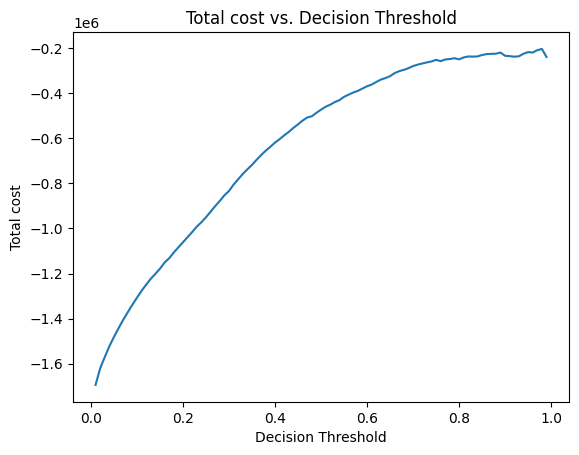

In [54]:
cb_column = 'A'
test_predictions_log_churn_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_churn_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_churn_2, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'churn_2')

Decision Threshold: 0.01, Test cost/loss = -1288372.80
Decision Threshold: 0.02, Test cost/loss = -1066025.64
Decision Threshold: 0.03, Test cost/loss = -927184.00
Decision Threshold: 0.04, Test cost/loss = -829236.34
Decision Threshold: 0.05, Test cost/loss = -758544.66
Decision Threshold: 0.06, Test cost/loss = -701162.24
Decision Threshold: 0.07, Test cost/loss = -651055.38
Decision Threshold: 0.08, Test cost/loss = -613263.40
Decision Threshold: 0.09, Test cost/loss = -576353.82
Decision Threshold: 0.10, Test cost/loss = -545150.66
Decision Threshold: 0.11, Test cost/loss = -519621.24
Decision Threshold: 0.12, Test cost/loss = -495342.22
Decision Threshold: 0.13, Test cost/loss = -470498.52
Decision Threshold: 0.14, Test cost/loss = -450201.78
Decision Threshold: 0.15, Test cost/loss = -433749.64
Decision Threshold: 0.16, Test cost/loss = -417323.92
Decision Threshold: 0.17, Test cost/loss = -402622.38
Decision Threshold: 0.18, Test cost/loss = -390698.60
Decision Threshold: 0.19, 

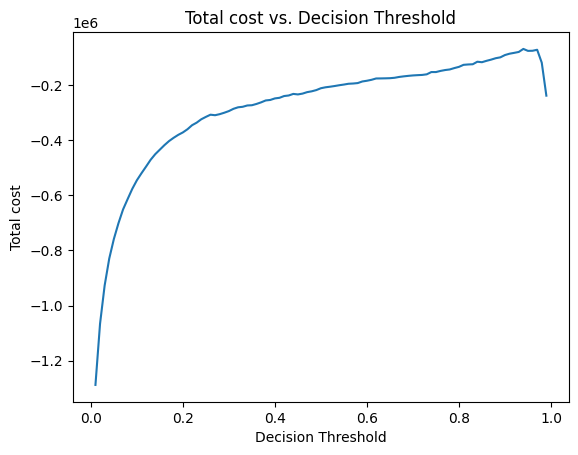

In [55]:
test_predictions_xgb_churn_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_churn_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_churn_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'churn_2' )

# E-MP metric

In [56]:
test_predictions_log_churn_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_churn_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1.0, 
    instance_dependent_cost_type="churn_2")
test_predictions_xgb_churn_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_churn_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1.0, 
    instance_dependent_cost_type="churn_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [57]:
print(test_predictions_log_churn_2['EAP'].sum())
print(test_predictions_log_churn_2['EP'].sum())


print('EAP : ', test_predictions_log_churn_2['EAP'].sum()/len(test_predictions_log_churn_2))
print('EP : ', test_predictions_log_churn_2['EP'].sum()/len(test_predictions_log_churn_2))

-634961.9841823193
-330237.0214677984
EAP :  -46.961170341122646
EP :  -24.424008687804037


In [58]:
print(test_predictions_xgb_churn_2['EAP'].sum())
print(test_predictions_xgb_churn_2['EP'].sum())


print('EAP : ', test_predictions_xgb_churn_2['EAP'].sum()/len(test_predictions_xgb_churn_2))
print('EP : ', test_predictions_xgb_churn_2['EP'].sum()/len(test_predictions_xgb_churn_2))

-286257.7422780964
-330237.0214677984
EAP :  -21.171344004000915
EP :  -24.424008687804037


# cost curves

In [59]:
total_fp_log_2 = 0

for i in range(0,13521):
    if test_predictions_log_churn['churn_encoded'].iloc[i] == 0 and test_predictions_log_churn['y_predicted'].iloc[i]==1:
        total_fp_log_2 += test_predictions_log_churn['FP'].iloc[i]
    else:
        total_fp_log_2 += 0

print(total_fp_log_2)

average_fp_log_2 = total_fp_log_2/13521
print( average_fp_log_2)

154084.22000000015
11.395918940906748


In [60]:
total_fn_log_2 = 0

for i in range(0,13521):
    if test_predictions_log_churn['churn_encoded'].iloc[i] == 1 and test_predictions_log_churn['y_predicted'].iloc[i]==0:
        total_fn_log_2 += test_predictions_log_churn['FN'].iloc[i]
    else:
        total_fn_log_2 += 0

print(total_fn_log_2)

average_fn_log_2 = total_fn_log_2/13521
print( average_fn_log_2)

10697.28
0.7911604171289106


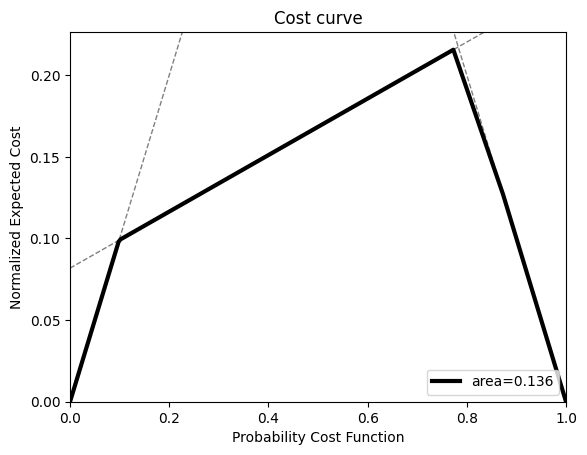

In [61]:
cost_fn_log_2 = average_fn_log_2
# C(+|-)
cost_fp_log_2 = average_fp_log_2

# Ground truth
truth = test_predictions_log_churn['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log_churn['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log_2) / (thresholds*cost_fn_log_2 + (1-thresholds)*cost_fp_log_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [62]:
total_fp_xgb_2 = 0

for i in range(0,13521):
    if test_predictions_xgb_churn['churn_encoded'].iloc[i] == 0 and test_predictions_xgb_churn['y_predicted'].iloc[i]==1:
        total_fp_xgb_2 += test_predictions_xgb_churn['FP'].iloc[i]
    else:
        total_fp_xgb_2 += 0

print(total_fp_xgb_2)

average_fp_xgb_2 = total_fp_xgb_2/13521
print( average_fp_xgb_2)

243956.66000000003
18.042797130389765


In [63]:
total_fn_xgb_2 = 0

for i in range(0,13521):
    if test_predictions_xgb_churn['churn_encoded'].iloc[i] == 1 and test_predictions_xgb_churn['y_predicted'].iloc[i]==0:
        total_fn_xgb_2 += test_predictions_xgb_churn['FN'].iloc[i]
    else:
        total_fn_xgb_2 += 0

print(total_fn_xgb_2)

average_fn_xgb_2 = total_fn_xgb_2/13521
print( average_fn_xgb_2)

17552.760000000002
1.2981850454848016


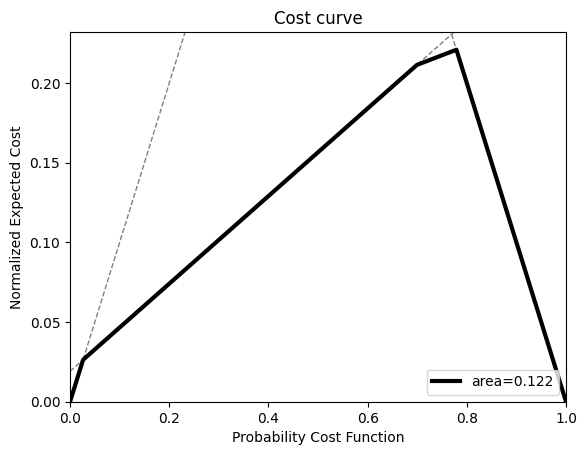

In [64]:
#C(-|+)
cost_fn_xgb_2 = average_fn_xgb_2
# C(+|-)
cost_fp_xgb_2 = average_fp_xgb_2

# Ground truth
truth = test_predictions_xgb_churn['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb_churn['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb_2) / (thresholds*cost_fn_xgb_2 + (1-thresholds)*cost_fp_xgb_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()